In [2]:
!pip list | grep opencv

opencv-contrib-python         4.1.2.30
opencv-python                 4.1.2.30


In [3]:
!pip uninstall opencv-python
!pip uninstall opencv-contrib-python

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python-4.1.2.30.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled opencv-python-4.1.2.30
Found existing installation: opencv-contrib-python 4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/opencv_contrib_python-4.1.2.30.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled opencv-contrib-python-4.1.2.30


In [4]:
!pip install opencv-contrib-python

     |████████████████████████████████| 66.5 MB 131 kB/s 


In [1]:
import keras.datasets.cifar10
import numpy as np

# Loading and preprocessing train and test datasets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
tmp_x_train = x_train
tmp_x_test = x_test
tmp_y_train = y_train.T[0].tolist()
tmp_y_test = y_test.T[0].tolist()

170508288/170498071 [==============================] - 6s 0us/step


In [112]:
lengths = [50 for x in range(10)]
tmp_x_train = []
tmp_y_train = []
for i in range(len(y_train)):
  for j in range(10):
    if lengths[j] != 0 and y_train[i] == j:
      tmp_x_train.append(x_train[i])
      tmp_y_train.append(y_train[i])
      lengths[j] -= 1

lengths = [10 for x in range(10)]
tmp_x_test = []
tmp_y_test = []
for i in range(len(y_test)):
  for j in range(10):
    if lengths[j] != 0 and y_test[i] == j:
      tmp_x_test.append(x_test[i])
      tmp_y_test.append(y_test[i])
      lengths[j] -= 1

In [2]:
import cv2
tmp_x_train = [cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in tmp_x_train]
x_train = np.array(tmp_x_train)
y_train = tmp_y_train

tmp_x_test = [cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in tmp_x_test]
x_test = np.array(tmp_x_test)
y_test = tmp_y_test

label_names = ["airplane", "automobile", "bird", "cat", \
               "deer", "dog"	,"frog"	,"horse", "ship", "truck"]
print("x_train:", type(x_train), x_train.shape)
print("y_train:", type(y_train), len(y_train))
print("x_test:", type(x_test), x_test.shape)
print("y_test:", type(y_test), len(y_test))

x_train: <class 'numpy.ndarray'> (50000, 32, 32)
y_train: <class 'list'> 50000
x_test: <class 'numpy.ndarray'> (10000, 32, 32)
y_test: <class 'list'> 10000


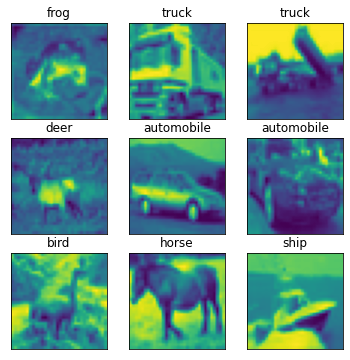

In [3]:
from matplotlib import pyplot as plt

# Representing some data
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(6, 6))
index = 0
for i in range(3):
    for j in range(3):
        axes[i,j].set_title(label_names[y_train[index]])
        axes[i,j].imshow(x_train[index])
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

In [4]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def extractingDescriptors(images):
  # Creating SIFT feature extractor
  sift = cv2.SIFT_create()

  descriptors_perImage = []
  for img in images:
      keypoints, descriptors = sift.detectAndCompute(img, None)
      descriptors_perImage.append(descriptors)
  return descriptors_perImage

def aggregatingDescriptors(descriptors_perImage):
  i = 0
  allDescriptors = None
  while i != len(descriptors_perImage):
    if descriptors_perImage[i] is not None:
      allDescriptors = np.array(descriptors_perImage[i])
      break
    else:
      i += 1

  for j in range(i+1, len(descriptors_perImage)):
      if descriptors_perImage[j] is not None:
          allDescriptors = np.vstack((allDescriptors, descriptors_perImage[j]))
  return allDescriptors
    
def clusteringDescriptors(allDescriptors, nCluster):
  kmeans = KMeans(n_clusters=nCluster).fit(allDescriptors)
  return kmeans

def extractingFeatures_perImage(kmeans, descriptors_perImage, nCluster):
  n = len(descriptors_perImage)
  imageFeatures = np.array([np.zeros(nCluster) for i in range(n)])
  for i in range(n):
    if descriptors_perImage[i] is not None:
      for j in range(len(descriptors_perImage[i])):
        feature = descriptors_perImage[i][j]
        feature = feature.reshape(1, 128)
        idx = kmeans.predict(feature)
        imageFeatures[i][idx] += 1
  return imageFeatures

def classifyingFeatures(imageFeatures, nNeighbors):
  KNN_classifier = KNeighborsClassifier(n_neighbors=nNeighbors)
  KNN_classifier.fit(imageFeatures, y_train)
  return KNN_classifier

def predictingImageLabels(imageFeatures, KNN_classifier):
  predictions = KNN_classifier.predict(imageFeatures)
  return predictions

def trainModel(x_train, y_train, nCluster, nNeighbors):
  print(" =====> Start Training Model <===== ")
  print("\n1_Extracting all descriptors per image")
  descriptors_perImage = extractingDescriptors(x_train)
  print("descriptors_perImage:", type(descriptors_perImage), len(descriptors_perImage))

  print("\n2_Aggregating all descriptors")
  allDescriptors = aggregatingDescriptors(descriptors_perImage)
  print("allDescriptors:", type(allDescriptors), allDescriptors.shape)
  print(allDescriptors)

  print("\n3_Clustering descriptors")
  kmeans = clusteringDescriptors(allDescriptors, nCluster)
  print("kmeans.cluster_centers_:", type(kmeans.cluster_centers_), kmeans.cluster_centers_.shape)
  print(kmeans.cluster_centers_)
 
  print("\n4_Extracting features per image")
  imageFeatures = extractingFeatures_perImage(kmeans, descriptors_perImage, nCluster)
  print("imageFeatures:", type(imageFeatures), imageFeatures.shape)
  print(imageFeatures)

  print("\n6_Classifying Features")
  KNN_classifier = classifyingFeatures(imageFeatures, nNeighbors)

  print("\n =====> End Training Model <===== \n")
  return kmeans, imageFeatures, KNN_classifier


def testModel(x_test, y_test, nCluster, kmeans, imageFeatures, KNN_classifier, label_names):
  print(" =====> Start Testing Model <===== ")
  print("\n1_Extracting all descriptors per image")
  test_descriptors_perImage = extractingDescriptors(x_test)
  print("test_descriptors_perImage:", type(test_descriptors_perImage), len(test_descriptors_perImage))

  print("\n2_Extracting features per image")
  test_imageFeatures = extractingFeatures_perImage(kmeans, test_descriptors_perImage, nCluster)
  print("test_imageFeatures:", type(test_imageFeatures), test_imageFeatures.shape)
  print(test_imageFeatures)

  print("\n3_Predicting image labels")
  predictions = predictingImageLabels(test_imageFeatures, KNN_classifier)
  print("predictions:", type(predictions), len(predictions))

  print('\nFinal Accuracy score is:', str(accuracy_score(y_test, predictions)*100)+" %")
  return accuracy_score(y_test, predictions)*100


nCluster = 20 # 2 per class
nNeighbors = 5
kmeans, imageFeatures, KNN_classifier = trainModel(x_train, y_train, nCluster, nNeighbors)
testModel(x_test, y_test, nCluster, kmeans, imageFeatures, KNN_classifier, label_names)

 =====> Start Training Model <===== 

1_Extracting all descriptors per image
descriptors_perImage: <class 'list'> 50000

2_Aggregating all descriptors
allDescriptors: <class 'numpy.ndarray'> (650337, 128)
[[ 0.  0.  0. ... 33. 33.  1.]
 [ 3.  0.  0. ...  0.  0.  0.]
 [19. 10.  5. ...  0.  9. 10.]
 ...
 [ 1.  1.  1. ...  0.  0. 61.]
 [ 3. 37. 58. ...  0.  0.  0.]
 [ 0.  0.  0. ... 28.  0.  0.]]

3_Clustering descriptors
kmeans.cluster_centers_: <class 'numpy.ndarray'> (20, 128)
[[17.761166  11.985902  10.642565  ... 24.08196    9.385292   7.872903 ]
 [26.712101  28.826422  21.965124  ...  5.980759   9.661675  15.215541 ]
 [15.569998   9.186544   9.772423  ...  5.666805   5.8222523 12.195969 ]
 ...
 [27.219341  18.111244  16.245747  ...  4.7429543  4.1299005  7.873619 ]
 [12.431017  10.027034  10.159676  ... 10.141801   9.440781  13.458293 ]
 [13.744852  14.65122   17.955917  ... 11.008543  13.718655  15.808788 ]]

4_Extracting features per image
imageFeatures: <class 'numpy.ndarray'> (5

17.49